In [1]:
cd '/Users/rabarry/Documents/Insight/NYC data/SafeEats/data/raw data'

/Users/rabarry/Documents/Insight/NYC data/SafeEats/data/raw data


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import seaborn as sns
import swifter
import qgrid
import datetime
from dateutil.relativedelta import relativedelta

# Initial data cleaning

In [3]:
HD = pd.read_csv('DOHMH_New_York_City_Restaurant_Inspection_Results.csv')

In [4]:
#cast date as date datatype
HD["INSPECTION DATE"] = pd.to_datetime(HD["INSPECTION DATE"])

In [5]:
#remove anything before 01-01-2014
HD = HD[HD["INSPECTION DATE"] > '2014-01-01']

In [6]:
HD = HD.sort_values("INSPECTION DATE")

In [7]:
len(HD["CAMIS"].unique())

25697

In [7]:
HD["CRITICAL FLAG"].value_counts()
HD['CRITICAL FLAG'].isnull().sum(axis = 0)
HD['Latitude'].isnull().sum(axis = 0)

Y    217897
N    171818
Name: CRITICAL FLAG, dtype: int64

7691

400

In [8]:
HD.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL',
       'NTA'],
      dtype='object')

# Recode critical flag so we can get a count of Y and N

In [9]:
def recode_critical (row):
    if row["CRITICAL FLAG"] == "Y":
        return 1
    else:
        return 0

In [10]:
HD['critical_flag_recode'] = HD.swifter.apply (lambda row: recode_critical(row), axis=1)

In [11]:
HD["critical_flag_recode"].value_counts()
HD['critical_flag_recode'].isnull().sum(axis = 0)

1    217897
0    179509
Name: critical_flag_recode, dtype: int64

0

# Recode Inspection Type

In [12]:
HD['INSPECTION TYPE'].value_counts()

Cycle Inspection / Initial Inspection                          232165
Cycle Inspection / Re-inspection                                96839
Pre-permit (Operational) / Initial Inspection                   27859
Pre-permit (Operational) / Re-inspection                        12230
Administrative Miscellaneous / Initial Inspection                7222
Cycle Inspection / Reopening Inspection                          4522
Pre-permit (Non-operational) / Initial Inspection                3501
Smoke-Free Air Act / Initial Inspection                          2142
Administrative Miscellaneous / Re-inspection                     2034
Trans Fat / Initial Inspection                                   1584
Pre-permit (Operational) / Compliance Inspection                 1268
Calorie Posting / Initial Inspection                             1208
Pre-permit (Operational) / Reopening Inspection                  1100
Inter-Agency Task Force / Initial Inspection                     1086
Cycle Inspection / C

In [13]:
mask = HD['INSPECTION TYPE'].str.contains(r'Initial', na= True)
HD.loc[mask,'inspection_type_recode']= 'Initial'
mask2 = HD['INSPECTION TYPE'].str.contains(r'Re-inspection', na= True)
HD.loc[mask2,'inspection_type_recode']= 'Re-inspection'
mask3 = HD['INSPECTION TYPE'].str.contains(r'Compliance', na= True)
HD.loc[mask3,'inspection_type_recode']= 'Initial'
mask4 = HD['INSPECTION TYPE'].str.contains(r'Reopening', na= True)
HD.loc[mask4,'inspection_type_recode']= 'Initial'
mask5 = HD['INSPECTION TYPE'].str.contains(r'Limited', na= True)
HD.loc[mask5,'inspection_type_recode']= 'Initial'
HD['inspection_type_recode'].value_counts()
HD['inspection_type_recode'].isnull().sum(axis = 0)

Initial          284855
Re-inspection    112551
Name: inspection_type_recode, dtype: int64

0

# Group by Restaurant and Inspection Date

In [48]:
HD_grouped = HD.groupby(["CAMIS", "INSPECTION DATE"]).agg({'critical_flag_recode': 'sum'})
HD_grouped.reset_index()
HD_grouped.head()
HD_grouped.tail()

,CAMIS,INSPECTION DATE,critical_flag_recode
0,30075445,2017-05-18,1
1,30075445,2018-05-11,0
2,30075445,2019-05-16,1
3,30075445,2019-06-11,0
4,30075445,2019-10-21,2
...,...,...,...
134435,50101998,2020-01-07,1
134436,50102076,2020-01-07,3
134437,50102276,2020-01-09,3
134438,50102300,2020-01-07,6


critical_flag_recode
CAMIS    INSPECTION DATE                      
30075445 2017-05-18                          1
         2018-05-11                          0
         2019-05-16                          1
         2019-06-11                          0
         2019-10-21                          2

,,critical_flag_recode
CAMIS,INSPECTION DATE,
50101998,2020-01-07,1
50102076,2020-01-07,3
50102276,2020-01-09,3
50102300,2020-01-07,6
50102397,2020-01-09,1


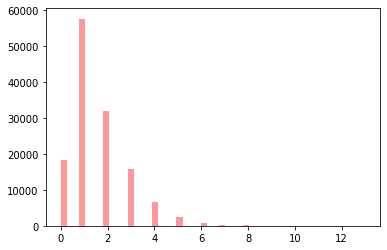

In [11]:
#pd.DataFrame.hist(HD_grouped)
sns.distplot(HD_grouped, kde=False, color='r')

# Group by cuisine type

In [12]:
HD_grouped_byCuisine = HD.groupby("CUISINE DESCRIPTION").agg({"critical_flag_recode":'sum', 'CAMIS':'count'})
HD_grouped_byCuisine=HD_grouped_byCuisine.reset_index()
HD_grouped_byCuisine['AVG_flags']= HD_grouped_byCuisine["critical_flag_recode"]/HD_grouped_byCuisine['CAMIS']
HD_grouped_byCuisine= HD_grouped_byCuisine.sort_values('CAMIS')
HD_grouped_byCuisine.head()
HD_grouped_byCuisine.tail()

,CUISINE DESCRIPTION,critical_flag_recode,CAMIS,AVG_flags
10,Basque,3,7,0.428571
18,Chilean,19,34,0.558824
25,Czech,23,41,0.560976
57,Nuts/Confectionary,15,43,0.348837
56,Not Listed/Not Applicable,35,64,0.546875


,CUISINE DESCRIPTION,critical_flag_recode,CAMIS,AVG_flags
51,"Latin (Cuban, Dominican, Puerto Rican, South &...",9945,17419,0.570928
62,Pizza,9564,17515,0.546046
13,Café/Coffee/Tea,9772,19420,0.503193
19,Chinese,24036,41896,0.573706
2,American,45029,83710,0.537917


(0.2, 0.6)

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'Average number of flags in the Top 5 most popular restaurant types')

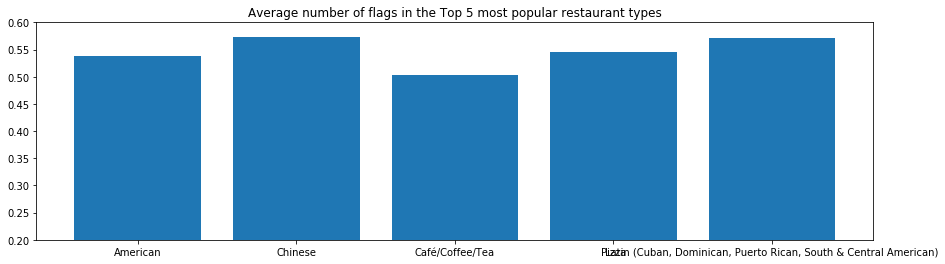

In [13]:
fig = plt.figure(figsize=(15,4))
plt.ylim(0.2,0.6)
HD_top5 = HD_grouped_byCuisine.nlargest(5,columns='CAMIS')
plt.bar(HD_top5["CUISINE DESCRIPTION"],HD_top5["AVG_flags"])
plt.title("Average number of flags in the Top 5 most popular restaurant types")

# Group by Restaurant

Text(0.5, 1.0, 'Total Number of Critical Violations')

(0, 40)

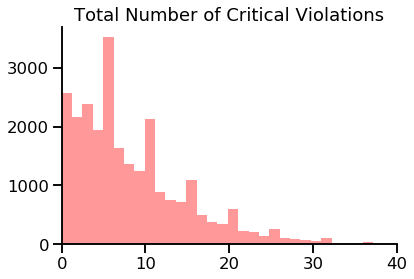

In [14]:
HD_grouped_byRest = HD.groupby("CAMIS").agg({'critical_flag_recode': 'sum'})
sns.set_context("talk")
sns.distplot(HD_grouped_byRest, kde=False, color='r')
sns.despine()
plt.title('Total Number of Critical Violations')
plt.xlim(0,40) 
HD_grouped_byRest.rename(columns = {'critical_flag_recode':'total_critical_flags'}, inplace = True)

### Find first and last inspection date for each restaurant

In [17]:
HD_grouped_minDate = HD.groupby("CAMIS").agg({'INSPECTION DATE': 'min'})
HD_grouped_minDate = HD_grouped_minDate.reset_index()
HD_grouped_minDate.columns = ['CAMIS', 'first_inspection_date']
len(HD_grouped_minDate)
HD_grouped_maxDate = HD.groupby("CAMIS").agg({'INSPECTION DATE': 'max'})
HD_grouped_maxDate = HD_grouped_maxDate.reset_index()
HD_grouped_maxDate.columns = ['CAMIS', 'last_inspection_date']
HD_grouped_maxDate.head()
len(HD_grouped_maxDate)

25697

,CAMIS,last_inspection_date
0,30075445,2019-11-04
1,30112340,2019-03-04
2,30191841,2019-06-06
3,40356018,2019-11-08
4,40356151,2018-10-06


25697

#### Merge first and last dates

In [18]:
HD_grouped_minmaxDate = pd.merge(HD_grouped_minDate, HD_grouped_maxDate, left_on = ['CAMIS'], right_on = ['CAMIS'], how = 'inner')
len(HD_grouped_minmaxDate)
HD_grouped_minmaxDate.head()
HD_grouped_minmaxDate.dtypes

25697

,CAMIS,first_inspection_date,last_inspection_date
0,30075445,2017-05-18,2019-11-04
1,30112340,2016-04-12,2019-03-04
2,30191841,2017-07-27,2019-06-06
3,40356018,2017-07-20,2019-11-08
4,40356151,2016-05-14,2018-10-06


CAMIS                             int64
first_inspection_date    datetime64[ns]
last_inspection_date     datetime64[ns]
dtype: object

#### Calculate number of years active

In [94]:
HD_grouped_minmaxDate['num_years_active'] = (HD_grouped_minmaxDate['last_inspection_date'] - HD_grouped_minmaxDate['first_inspection_date']).dt.days/365.25
HD_grouped_minmaxDate = HD_grouped_minmaxDate.set_index('CAMIS')
HD_grouped_minmaxDate['num_years_active'] = HD_grouped_minmaxDate['num_years_active'].round(0)
HD_grouped_minmaxDate.head()

,first_inspection_date,last_inspection_date,num_years_active
CAMIS,,,
30075445,2017-05-18,2019-11-04,2.0
30112340,2016-04-12,2019-03-04,3.0
30191841,2017-07-27,2019-06-06,2.0
40356018,2017-07-20,2019-11-08,2.0
40356151,2016-05-14,2018-10-06,2.0


#### Calculate average number of years

In [97]:
HD_grouped_byRest_Years = pd.merge(HD_grouped_byRest, HD_grouped_minmaxDate, left_on = ['CAMIS'], right_on = ['CAMIS'], how = 'inner')
len(HD_grouped_byRest_Years)
HD_grouped_byRest_Years['avg_num_critical_flags_per_year'] = HD_grouped_byRest_Years['total_critical_flags']/HD_grouped_byRest_Years['num_years_active']
HD_grouped_byRest_Years.head()
HD_grouped_byRest_Years.dtypes

25697

,total_critical_flags,first_inspection_date,last_inspection_date,num_years_active,avg_num_critical_flags_per_year
CAMIS,,,,,
30075445,5,2017-05-18,2019-11-04,2.0,2.5
30112340,9,2016-04-12,2019-03-04,3.0,3.0
30191841,5,2017-07-27,2019-06-06,2.0,2.5
40356018,3,2017-07-20,2019-11-08,2.0,1.5
40356151,4,2016-05-14,2018-10-06,2.0,2.0


total_critical_flags                        int64
first_inspection_date              datetime64[ns]
last_inspection_date               datetime64[ns]
num_years_active                          float64
avg_num_critical_flags_per_year           float64
dtype: object

#### For places with only one inspection, need to replace avg_num_critical_flags_per_year with total_critical_flags

In [98]:
HD_grouped_byRest_Years.loc[HD_grouped_byRest_Years['num_years_active']== 0, 'avg_num_critical_flags_per_year'] = HD_grouped_byRest_Years['total_critical_flags']

In [104]:
HD_grouped_byRest_Years['avg_num_critical_flags_per_year'].min()
HD_grouped_byRest_Years['avg_num_critical_flags_per_year'].max()
HD_grouped_byRest_Years.loc[HD_grouped_byRest_Years['avg_num_critical_flags_per_year'].idxmax()]
len(HD_grouped_byRest_Years)
HD_grouped_byRest_Years.to_csv(r'HD_grouped_byRest_Years.csv')

0.0

36.0

total_critical_flags                                36
first_inspection_date              2018-12-05 00:00:00
last_inspection_date               2019-12-24 00:00:00
num_years_active                                     1
avg_num_critical_flags_per_year                     36
Name: 50085705, dtype: object

25697

# create a list to use for searching yelp

In [91]:
yelp_list = HD[['CAMIS', 'DBA', 'BORO', 'ZIPCODE', 'PHONE', 'Latitude', 'Longitude']]
#remove duplicates
yelp_list_stripped = yelp_list.drop_duplicates(['CAMIS'])
yelp_list_stripped.head()

,CAMIS,DBA,BORO,ZIPCODE,PHONE,Latitude,Longitude
13541,50003303,BROOKLYN SWEET SPOT,Brooklyn,11205.0,7185222577,40.693184,-73.971562
4045,41308050,RELISH CONCESSIONS (LASKER RINK),Manhattan,NaN,9174923856,0.000000,0.000000
388145,41702635,KAPPOCK CAFE,Bronx,10463.0,7186015500,40.878731,-73.917529
140010,50012569,CASA MEXICANA,Manhattan,10025.0,2122223151,40.799035,-73.966742
231232,50000233,PALM COURT,Manhattan,10019.0,2127593000,40.764148,-73.973951


# Do some cleaning for yelp search

In [92]:
yelp_list_stripped['Latitude'].value_counts()
yelp_list_stripped['Longitude'].value_counts()
yelp_list_stripped['Latitude']=yelp_list_stripped['Latitude'].fillna(0)
yelp_list_stripped['Longitude']=yelp_list_stripped['Longitude'].fillna(0)
yelp_list_stripped['DBA_clean'] = yelp_list_stripped['DBA'].str.split('#').str[0] 
yelp_list_stripped.head()

0.000000     399
40.648313    118
40.750655     67
40.774414     61
40.829028     45
            ... 
40.610341      1
40.713265      1
40.735671      1
40.725661      1
40.737156      1
Name: Latitude, Length: 21746, dtype: int64

 0.000000     399
-73.788281    118
-73.991944     67
-73.877293     61
-73.928496     45
             ... 
-73.877641      1
-73.935739      1
-73.955130      1
-73.954514      1
-73.707634      1
Name: Longitude, Length: 21746, dtype: int64

/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

,CAMIS,DBA,BORO,ZIPCODE,PHONE,Latitude,Longitude,DBA_clean
13541,50003303,BROOKLYN SWEET SPOT,Brooklyn,11205.0,7185222577,40.693184,-73.971562,BROOKLYN SWEET SPOT
4045,41308050,RELISH CONCESSIONS (LASKER RINK),Manhattan,NaN,9174923856,0.000000,0.000000,RELISH CONCESSIONS (LASKER RINK)
388145,41702635,KAPPOCK CAFE,Bronx,10463.0,7186015500,40.878731,-73.917529,KAPPOCK CAFE
140010,50012569,CASA MEXICANA,Manhattan,10025.0,2122223151,40.799035,-73.966742,CASA MEXICANA
231232,50000233,PALM COURT,Manhattan,10019.0,2127593000,40.764148,-73.973951,PALM COURT


In [23]:
yelp_list_stripped.to_csv(r'Restaurant_List.csv')

# Number of Critical Violations at Most Recent Inspection

In [49]:
HD_AllInsp = HD.groupby(["CAMIS","INSPECTION DATE", 'inspection_type_recode']).agg({'critical_flag_recode': 'sum'})
HD_AllInsp = HD_AllInsp.reset_index()
len(HD_AllInsp)
len(HD_AllInsp['CAMIS'].unique())

134718

25697

In [50]:
HD_LastInsp = HD_AllInsp.sort_values('INSPECTION DATE').groupby('CAMIS').last()
HD_LastInsp = HD_LastInsp.reset_index()
HD_LastInsp = HD_LastInsp.sort_values('critical_flag_recode')
HD_LastInsp = HD_LastInsp[['CAMIS', 'inspection_type_recode', 'INSPECTION DATE', 'critical_flag_recode']]
HD_LastInsp.head()
HD_LastInsp.tail()
len(HD_LastInsp)

,CAMIS,inspection_type_recode,INSPECTION DATE,critical_flag_recode
12848,50018118,Initial,2019-06-20,0
5947,41405616,Initial,2019-10-18,0
18423,50066704,Initial,2019-11-29,0
5936,41404371,Initial,2019-03-12,0
18443,50066822,Initial,2019-03-27,0


,CAMIS,inspection_type_recode,INSPECTION DATE,critical_flag_recode
15174,50046648,Re-inspection,2019-12-02,9
593,40393488,Initial,2019-08-23,9
22655,50086495,Initial,2019-12-26,9
16810,50057515,Re-inspection,2019-05-21,9
22653,50086483,Initial,2019-05-30,10


25697

In [51]:
HD_LastInsp.critical_flag_recode.value_counts()

1     14180
2      4803
0      4295
3      1392
4       650
5       254
6        74
7        30
8        13
9         5
10        1
Name: critical_flag_recode, dtype: int64

(-0.5, 6.5)

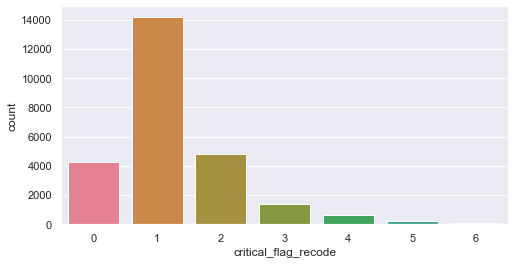

In [60]:
sns.set(rc={'figure.figsize':(8,4)})
ax = sns.countplot(x=HD_LastInsp['critical_flag_recode'], palette = 'husl')
sns.despine()
plt.xlim(-.5,6.5) 
plt.savefig('/Users/rabarry/Documents/Insight/NYC data/SafeEats/Violations_Countplot.png')
plt.savefig('histogram.png')

# Second to last date

In [359]:
HD_SecondLastInsp = HD.groupby(["CAMIS", "INSPECTION DATE"]).agg({'critical_flag_recode': 'sum'})
HD_SecondLastInsp = HD_SecondLastInsp.reset_index()
len(HD_SecondLastInsp)
HD_SecondLastInsp = HD_SecondLastInsp.sort_values("INSPECTION DATE", ascending = False)
HD_SecondLastInsp.head()

134440

,CAMIS,INSPECTION DATE,critical_flag_recode
36623,41427508,2020-01-11,2
98268,50053253,2020-01-11,0
118945,50073170,2020-01-11,3
131163,50089796,2020-01-11,3
72944,50012264,2020-01-11,1


In [360]:
HD_SecondLastInsp = HD_SecondLastInsp.groupby("CAMIS")['INSPECTION DATE'].apply(lambda x: x.nlargest(2).min())
HD_SecondLastInsp = HD_SecondLastInsp.to_frame()
len(HD_SecondLastInsp)
HD_SecondLastInsp.head()

25697

,INSPECTION DATE
CAMIS,
30075445,2019-10-21
30112340,2018-03-13
30191841,2018-05-16
40356018,2018-10-30
40356151,2017-08-19


In [320]:
#change index to be CAMIS
HD_AllInsp = HD_AllInsp.set_index('CAMIS')
HD_AllInsp.head()
HD_LastInsp = HD_LastInsp.set_index('CAMIS')
HD_LastInsp.head()
HD_SecondLastInsp.head()

,INSPECTION DATE,inspection_type_recode,critical_flag_recode
CAMIS,,,
30075445,2017-05-18,Initial,1
30075445,2018-05-11,Initial,0
30075445,2019-05-16,Initial,1
30075445,2019-06-11,Re-inspection,0
30075445,2019-10-21,Initial,2


,inspection_type_recode,INSPECTION DATE,critical_flag_recode
CAMIS,,,
50018118,Initial,2019-06-20,0
41405616,Initial,2019-10-18,0
50066704,Initial,2019-11-29,0
41404371,Initial,2019-03-12,0
50066822,Initial,2019-03-27,0


,INSPECTION DATE
CAMIS,
30075445,2019-10-21
30112340,2018-03-13
30191841,2018-05-16
40356018,2018-10-30
40356151,2017-08-19


# Join the 3 tables back into 1

In [341]:
HD_AllInsp = HD_AllInsp.sort_values(['CAMIS','INSPECTION DATE'])

In [331]:
dupe_camis
#Recoded duplicate rows as Re-inspection if labeled as both Re-inspection and Initial-- just did it in excel and re-loaded

array([40368291, 40385693, 40690899, 40704315, 40792980, 40795021,
       41009687, 41067651, 41076314, 41163474, 41227842, 41255390,
       41298790, 41303343, 41310578, 41336495, 41451015, 41572121,
       41604594, 41618541, 41632866, 41718215, 50004837, 50005142,
       50005692, 50006614, 50013897, 50033010, 50034635, 50038157,
       50043179, 50046056, 50047766, 50053023, 50054551, 50057811,
       50063824, 50067622, 50067629, 50068366, 50071254, 50075728,
       50077039, 50077853, 50083456, 50083891, 50084908, 50084943,
       50089649, 50089730])

In [356]:
HD_AllInsp = pd.read_csv('HD_AllInsp.csv', index_col = 0)
#cast date as date datatype
HD_AllInsp["INSPECTION DATE"] = pd.to_datetime(HD_AllInsp["INSPECTION DATE"])
HD_AllInsp.head()
len(HD_AllInsp)

,INSPECTION DATE,inspection_type_recode,critical_flag_recode
CAMIS,,,
30075445,2017-05-18,Initial,1
30075445,2018-05-11,Initial,0
30075445,2019-05-16,Initial,1
30075445,2019-06-11,Re-inspection,0
30075445,2019-10-21,Initial,2


134718

In [357]:
HD_AllInsp = HD_AllInsp.groupby(["CAMIS", 'INSPECTION DATE', 'inspection_type_recode']).agg({'critical_flag_recode': 'sum'})
HD_AllInsp = HD_AllInsp.reset_index()
HD_AllInsp = HD_AllInsp.set_index('CAMIS')
len(HD_AllInsp)

134665

In [361]:
#merge the SecondLast df with the AllInsp df to recover the critical flag counts
HD_SecondLastInsp = HD_SecondLastInsp.merge(HD_AllInsp, left_on = ['CAMIS', 'INSPECTION DATE'], right_on = ['CAMIS', 'INSPECTION DATE'], how = 'left')
len(HD_SecondLastInsp)
HD_SecondLastInsp.head()

25697

,INSPECTION DATE,inspection_type_recode,critical_flag_recode
CAMIS,,,
30075445,2019-10-21,Initial,2
30112340,2018-03-13,Initial,1
30191841,2018-05-16,Initial,1
40356018,2018-10-30,Initial,1
40356151,2017-08-19,Initial,1


In [327]:
#find duplicates
#dupes = HD_SecondLastInsp.groupby(level=0).filter(lambda x: len(x) > 1)
#dupes = dupes.reset_index()
#dupe_camis = dupes['CAMIS']
#dupe_camis = dupe_camis.unique()
#len(dupe_camis)

In [365]:
len(HD_SecondLastInsp)
HD_SecondLastInsp = HD_SecondLastInsp[['inspection_type_recode', 'INSPECTION DATE', 'critical_flag_recode']]
HD_SecondLastInsp.columns = ['Second_Last_Insp_Type','Second_Last_Insp_Date', 'Second_Last_Insp_Num_CriticialFlags']
HD_SecondLastInsp = HD_SecondLastInsp.sort_values('CAMIS')
HD_SecondLastInsp.head()

25697

,Second_Last_Insp_Type,Second_Last_Insp_Date,Second_Last_Insp_Num_CriticialFlags
CAMIS,,,
30075445,Initial,2019-10-21,2
30112340,Initial,2018-03-13,1
30191841,Initial,2018-05-16,1
40356018,Initial,2018-10-30,1
40356151,Initial,2017-08-19,1


In [366]:
len(HD_LastInsp)
HD_LastInsp.columns = ['Last_Insp_Type','Last_Insp_Date', 'Last_Insp_Num_CriticialFlags']
HD_LastInsp = HD_LastInsp.sort_values('CAMIS')
HD_LastInsp.head()

25697

,Last_Insp_Type,Last_Insp_Date,Last_Insp_Num_CriticialFlags
CAMIS,,,
30075445,Re-inspection,2019-11-04,1
30112340,Initial,2019-03-04,1
30191841,Initial,2019-06-06,1
40356018,Initial,2019-11-08,1
40356151,Initial,2018-10-06,2


In [367]:
#merge the SecondLast df with the LastInsp df 
HD_InspCounts = pd.merge(HD_SecondLastInsp, HD_LastInsp, left_on = 'CAMIS', right_on = 'CAMIS', how = 'inner')
len(HD_InspCounts)
HD_InspCounts.head()

25697

,Second_Last_Insp_Type,Second_Last_Insp_Date,Second_Last_Insp_Num_CriticialFlags,Last_Insp_Type,Last_Insp_Date,Last_Insp_Num_CriticialFlags
CAMIS,,,,,,
30075445,Initial,2019-10-21,2,Re-inspection,2019-11-04,1
30112340,Initial,2018-03-13,1,Initial,2019-03-04,1
30191841,Initial,2018-05-16,1,Initial,2019-06-06,1
40356018,Initial,2018-10-30,1,Initial,2019-11-08,1
40356151,Initial,2017-08-19,1,Initial,2018-10-06,2


In [368]:
HD_InspCounts['Insp_Date_Diff']=HD_InspCounts['Last_Insp_Date'] - HD_InspCounts['Second_Last_Insp_Date']
HD_InspCounts.head()

,Second_Last_Insp_Type,Second_Last_Insp_Date,Second_Last_Insp_Num_CriticialFlags,Last_Insp_Type,Last_Insp_Date,Last_Insp_Num_CriticialFlags,Insp_Date_Diff
CAMIS,,,,,,,
30075445,Initial,2019-10-21,2,Re-inspection,2019-11-04,1,14 days
30112340,Initial,2018-03-13,1,Initial,2019-03-04,1,356 days
30191841,Initial,2018-05-16,1,Initial,2019-06-06,1,386 days
40356018,Initial,2018-10-30,1,Initial,2019-11-08,1,374 days
40356151,Initial,2017-08-19,1,Initial,2018-10-06,2,413 days


It turns out that for some of these, we only have 1 inspection. So Second_Last_Date is equal to Last_Date because of the way I calculated it. So we need to get rid of those guys

In [369]:
HD_InspCounts['Insp_Date_Diff'].min()
HD_InspCounts['Insp_Date_Diff'].max()

Timedelta('0 days 00:00:00')

Timedelta('1071 days 00:00:00')

In [370]:
HD_InspCounts.loc[HD_InspCounts['Insp_Date_Diff'] == '0 days', ['Second_Last_Insp_Type','Second_Last_Insp_Num_CriticialFlags','Second_Last_Insp_Date']] = np.NaN

In [371]:
HD_InspCounts[HD_InspCounts['Insp_Date_Diff']=='0 days']
len(HD_InspCounts[HD_InspCounts['Insp_Date_Diff']=='0 days'])

,Second_Last_Insp_Type,Second_Last_Insp_Date,Second_Last_Insp_Num_CriticialFlags,Last_Insp_Type,Last_Insp_Date,Last_Insp_Num_CriticialFlags,Insp_Date_Diff
CAMIS,,,,,,,
40962072,NaN,NaT,NaN,Initial,2018-05-10,1,0 days
41412172,NaN,NaT,NaN,Initial,2015-10-03,1,0 days
41601082,NaN,NaT,NaN,Initial,2019-02-12,4,0 days
50043445,NaN,NaT,NaN,Initial,2017-03-10,1,0 days
50066403,NaN,NaT,NaN,Initial,2018-08-30,1,0 days
...,...,...,...,...,...,...,...
50101998,NaN,NaT,NaN,Initial,2020-01-07,1,0 days
50102076,NaN,NaT,NaN,Initial,2020-01-07,3,0 days
50102276,NaN,NaT,NaN,Initial,2020-01-09,3,0 days


1903

In [377]:
#merge with original 
HD_InspCounts_Full = pd.merge(HD_InspCounts, HD, left_on = ['CAMIS', 'Last_Insp_Date'], right_on = ['CAMIS', 'INSPECTION DATE'], how = 'left')
len(HD_InspCounts_Full)

67090

In [381]:
#Drop duplicate rows that got added from the full dataframe
HD_InspCounts_Full = HD_InspCounts_Full.drop_duplicates(subset = 'CAMIS', keep = 'first')
len(HD_InspCounts_Full)

25697

In [386]:
HD_InspCounts_Full = HD_InspCounts_Full[['CAMIS', 'Second_Last_Insp_Type', 'Second_Last_Insp_Date',
       'Second_Last_Insp_Num_CriticialFlags', 'Last_Insp_Type',
       'Last_Insp_Date', 'Last_Insp_Num_CriticialFlags', 'Insp_Date_Diff','DBA', 'BORO', 'ZIPCODE',
       'CUISINE DESCRIPTION',  'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL',
       'NTA']]
HD_InspCounts_Full.head(n=2)

,CAMIS,Second_Last_Insp_Type,Second_Last_Insp_Date,Second_Last_Insp_Num_CriticialFlags,Last_Insp_Type,Last_Insp_Date,Last_Insp_Num_CriticialFlags,Insp_Date_Diff,DBA,BORO,ZIPCODE,CUISINE DESCRIPTION,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,30075445,Initial,2019-10-21,2.0,Re-inspection,2019-11-04,1,14 days,MORRIS PARK BAKE SHOP,Bronx,10462.0,Bakery,40.848231,-73.855972,211.0,13.0,25200.0,2045445.0,2.041270e+09,BX37
1,30112340,Initial,2018-03-13,1.0,Initial,2019-03-04,1,356 days,WENDY'S,Brooklyn,11225.0,Hamburgers,40.662652,-73.962081,309.0,40.0,32700.0,3029737.0,3.011970e+09,BK60


In [387]:
#save this dataframe to file
HD_InspCounts_Full.to_csv(r'HD_InspCounts_Full.csv')